## Chloe's Explore Notebook for the NLP Group Project

### Imports

In [1]:
import pandas as pd
import numpy as np

# Scraping
import requests
from bs4 import BeautifulSoup

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk.sentiment

from wordcloud import WordCloud

# Regex
import re

# Time
from time import strftime

import unicodedata
import json
from pprint import pprint

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Imports
import acquire 
from prepare import *

# Turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# pd.set_option('display.max_colwidth', -1)

### Acquire

In [2]:
# acquire.scrape_github_data()

In [3]:
# df = pd.DataFrame(acquire.scrape_github_data(),columns=['repo','language','readme_contents'])
# df.head()


In [4]:
df = pd.read_json('repo_readmes.json')

In [5]:
df.shape

(180, 3)

In [6]:
original = pd.read_json('repo_readmes.json')
print(original)

                                 repo          language  \
0           using-system/LightningPay                C#   
1     drminnaar/react-bitcoin-monitor        JavaScript   
2                      lbryio/lbrycrd               C++   
3    ElementsProject/lightning-charge        JavaScript   
4            kilimchoi/cryptocurrency              None   
..                                ...               ...   
175           justinmoon/digital-cash            Python   
176      richardgill/BitcoinEmissions              None   
177                 BlueWallet/LndHub        JavaScript   
178              Cvar1984/pemulungBTC               PHP   
179             TheDoctorAI/AI-Trader  Jupyter Notebook   

                                       readme_contents  
0    # LightningPay\nBitcoin Lightning Network Paym...  
1    # React Bitcoin Monitor\n\nAn app that monitor...  
2    # LBRYcrd - The LBRY blockchain\n\n[![Build St...  
3    # Lightning Charge\n\n[![build status](https:/...  
4    C

### Prepare

In [7]:
df.head()

,repo,language,readme_contents
0,using-system/LightningPay,C#,# LightningPay\nBitcoin Lightning Network Paym...
1,drminnaar/react-bitcoin-monitor,JavaScript,# React Bitcoin Monitor\n\nAn app that monitor...
2,lbryio/lbrycrd,C++,# LBRYcrd - The LBRY blockchain\n\n[![Build St...
3,ElementsProject/lightning-charge,JavaScript,# Lightning Charge\n\n[![build status](https:/...
4,kilimchoi/cryptocurrency,None,Check out https://coinbuddy.co/coins to track ...


In [8]:
# if you want to see the whole column contents:
# pd.set_option('display.max_colwidth', -1)

In [9]:
# how many language observations do we have?

df.language.value_counts(normalize = True)

JavaScript          0.253012
Python              0.204819
C++                 0.096386
PHP                 0.090361
C                   0.066265
HTML                0.042169
Go                  0.042169
Java                0.030120
Ruby                0.030120
Jupyter Notebook    0.024096
C#                  0.024096
Shell               0.018072
TypeScript          0.018072
Perl                0.006024
Prolog              0.006024
Dart                0.006024
VHDL                0.006024
R                   0.006024
Vue                 0.006024
SCSS                0.006024
CoffeeScript        0.006024
Rust                0.006024
CSS                 0.006024
Name: language, dtype: float64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             180 non-null    object
 1   language         166 non-null    object
 2   readme_contents  180 non-null    object
dtypes: object(3)
memory usage: 5.6+ KB


Split data since we will be modeling. 

In [11]:
df.isnull().sum()

repo                0
language           14
readme_contents     0
dtype: int64

In [12]:
# drop null rows for specific columns only
df = df[df.language.notnull()]

In [13]:
df.isnull().sum()

repo               0
language           0
readme_contents    0
dtype: int64

In [14]:
df.language.value_counts()

JavaScript          42
Python              34
C++                 16
PHP                 15
C                   11
HTML                 7
Go                   7
Java                 5
Ruby                 5
C#                   4
Jupyter Notebook     4
Shell                3
TypeScript           3
Perl                 1
Vue                  1
Prolog               1
Dart                 1
CSS                  1
R                    1
SCSS                 1
CoffeeScript         1
Rust                 1
VHDL                 1
Name: language, dtype: int64

In [15]:
def common_language(string):
    """
    Takes in a string and compares it to a predefined user list
    if string not in list changes to 'Other'
    """
    language_list= ['JavaScript', 'Python', 'C++', 'PHP', 'C', 'Java']
    if string not in language_list:
        string = 'Other'
    return string

   # Save the names of the top 5 programming languages, and change the rest to 'Other'
    df['language'] = df.language.apply(common_language)

In [16]:
df['language'] = df.language.apply(common_language)

In [17]:
# how many language observations do we have?

df.language.value_counts(normalize = True)

Other         0.259036
JavaScript    0.253012
Python        0.204819
C++           0.096386
PHP           0.090361
C             0.066265
Java          0.030120
Name: language, dtype: float64

In [18]:
# drop_list = ['CoffeeScript',
# 'R',
# 'CSS',
# 'Prolog',
# 'Vue',
# 'Dart',
# 'Rust',
# 'SCSS',
# 'Perl',
# 'VHDL',
# 'Shell', 
# 'TypeScript'
# ]

In [19]:
# # DROPPING LANGUAGES THAT HAVE FEWER THAN ONE INSTANCE
# # BC IT CREATES PROBLEMS FOR SPLITTING THE DATA
# df = df[~df.language.isin(drop_list)]


In [20]:
df = prep_readme_data(df, 'readme_contents', extra_words=[], exclude_words=[])
df.sample(5)

,repo,language,readme_contents,clean,stemmed,lemmatized
61,interplanaria/bitwork,JavaScript,# bitwork\n\n> Bitcoin networking made simple....,bitwork bitcoin networking made simple bitwork...,bitwork bitcoin network made simpl bitwork eas...,bitwork bitcoin networking made simple bitwork...
55,domob1812/namecoin-core,C++,Namecoin Core integration/staging tree\n======...,namecoin core integrationstaging tree build st...,namecoin core integrationstag tree build statu...,namecoin core integrationstaging tree build st...
113,LarsHoldgaard/bitcoin-wrapper,JavaScript,This is a Bitcoin qt wrapper for .NET. It is w...,bitcoin qt wrapper net written c made june 201...,thi bitcoin qt wrapper net written c made june...,bitcoin qt wrapper net written c made june 201...
126,bitpay/foxtrot,JavaScript,# Foxtrot\n[![NPM Package](https://img.shields...,foxtrot npm packagehttpsimgshieldsionpmvfoxtro...,foxtrot npm packagehttpsimgshieldsionpmvfoxtro...,foxtrot npm packagehttpsimgshieldsionpmvfoxtro...
152,bitcoin-resources/bitcoin-resources.github.io,Other,# Bitcoin Resources\n\nA curated collection of...,bitcoin resources curated collection articles ...,bitcoin resourc curat collect articl book podc...,bitcoin resource curated collection article bo...


In [21]:
df=df.drop(columns=['readme_contents', 'clean', 'stemmed'])
df.head()

,repo,language,lemmatized
0,using-system/LightningPay,Other,lightningpay bitcoin lightning network payment...
1,drminnaar/react-bitcoin-monitor,JavaScript,react bitcoin monitor app monitor change _bitc...
2,lbryio/lbrycrd,C++,lbrycrd lbry blockchain build statushttpstravi...
3,ElementsProject/lightning-charge,JavaScript,lightning charge build statushttpsapitraviscio...
5,tip4commit/tip4commit,Other,tip4commit tip next commithttpstip4commitcompr...


In [22]:
# SPLIT
from sklearn.model_selection import train_test_split
# Test set is .2 of original dataframe
train, test = train_test_split(df, test_size = .2, random_state=42, stratify= df.language)
# The remainder is here divided .7 to train and .3 to validate
train, validate = train_test_split(train, test_size=.3, random_state=42, stratify= train.language)
train.shape, validate.shape, test.shape

((92, 3), (40, 3), (34, 3))

In [23]:
X_train = train.drop(columns=['language'])
y_train = pd.DataFrame(train.language, columns=['language'])

X_validate = validate.drop(columns=['language'])
y_validate = pd.DataFrame(validate.language, columns=['language'])

X_test = test.drop(columns=['language'])
y_test = pd.DataFrame(test.language, columns=['language'])

train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((92, 3),
 (40, 3),
 (34, 3),
 (92, 2),
 (92, 1),
 (40, 2),
 (40, 1),
 (34, 2),
 (34, 1))

In [24]:
# how many language observations do we have?

train.language.value_counts(normalize = True)

Other         0.260870
JavaScript    0.250000
Python        0.206522
C++           0.097826
PHP           0.086957
C             0.065217
Java          0.032609
Name: language, dtype: float64

In [25]:
# remove_stopwords(str(train.lemmatized))

In [26]:
# combine all contents in single string by language

javascript_words = (' '.join(train[train.language == 'JavaScript'].lemmatized))
c_plus_plus__words = (' '.join(train[train.language == 'C++'].lemmatized))
c_words = (' '.join(train[train.language == 'C'].lemmatized))
python_words = (' '.join(train[train.language == 'Python'].lemmatized))
php_words = (' '.join(train[train.language == 'PHP'].lemmatized))
java_words = (' '.join(train[train.language == 'Java'].lemmatized))
other_words = (' '.join(train[train.language == 'Other'].lemmatized))
all_words = (' '.join(train.lemmatized))

In [27]:
# all_words

In [28]:
javascript_words = remove_stopwords(str(javascript_words))

In [29]:
c_plus_plus__words = remove_stopwords(str(c_plus_plus__words))

In [30]:
c_words = remove_stopwords(str(c_words))

In [31]:
python_words = remove_stopwords(str(python_words))

In [32]:
java_words = remove_stopwords(str(java_words))

In [33]:
php_words = remove_stopwords(str(php_words))

In [34]:
other_words = remove_stopwords(str(other_words))

In [35]:
all_words = remove_stopwords(str(all_words))

### Explore

Possible Questions: 

- What are the most common words in READMEs?
- What does the distribution of IDFs look like for the most common words?
- Does the length of the README vary by programming language?
- Do different programming languages use a different number of unique words?

In [36]:
# represent contents as word frequencies

javascript_freq = pd.Series(javascript_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus__words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
other_freq = pd.Series(other_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [37]:
# concat all frequencies together into a dataframe

word_counts = pd.concat([javascript_freq, c_plus_plus_freq, c_freq, python_freq, java_freq, php_freq, other_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['javascript', 'c_plus_plus', 'c', 'python', 'java', 'php', 'other', 'all']
word_counts.head()

,javascript,c_plus_plus,c,python,java,php,other,all
td,321,0,0,0,0,0,0,321
bitcoin,104,27,8,60,6,28,62,295
transaction,74,0,0,24,1,3,25,127
data,73,9,6,24,0,4,4,120
bitwork,72,0,0,0,0,0,0,72


In [38]:
java_freq

support      12
wallet       10
key           7
bitcoin       6
import        5
             ..
currently     1
prevent       1
compiler      1
150           1
leave         1
Length: 144, dtype: int64

- What are the most frequently occuring words? 

- Are there words that uniquely identify with a certain language's repos? 


In [39]:
# most frequently occuring words: sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,javascript,c_plus_plus,c,python,java,php,other,all
td,321,0,0,0,0,0,0,321
address,52,106,12,26,5,69,37,307
bitcoin,104,27,8,60,6,28,62,295
run,68,36,5,25,2,9,82,227
key,11,136,11,28,7,12,17,222
file,20,31,25,22,1,17,42,158
use,40,31,20,16,1,18,32,158
&#9;,2,79,1,0,1,5,69,157
install,32,15,13,36,1,8,50,155
info,10,129,4,2,0,3,1,149


In [119]:
# requently occuring words by language: sort by language
word_counts_sorted = word_counts.sort_values(['javascript', 'c_plus_plus', 'c', 'python', 'java', 'php', 'other', 'all'], ascending=[False, False, False, False, False, False, False, False]).head(20)

In [120]:
word_counts_sorted

,javascript,c_plus_plus,c,python,java,php,other,all
td,321,0,0,0,0,0,0,321
bitcoin,104,27,8,60,6,28,62,295
transaction,74,0,0,24,1,3,25,127
data,73,9,6,24,0,4,4,120
block,72,12,0,9,1,2,2,98
bitwork,72,0,0,0,0,0,0,72
run,68,36,5,25,2,9,82,227
npm,63,0,0,0,0,0,12,75
const,63,0,0,0,0,0,6,69
return,55,0,0,1,0,6,1,63


- least common and most common words for each language. 

In [42]:
java_freq.idxmin(), java_freq.idxmax()

('passphrase', 'support')

In [43]:
c_plus_plus_freq.idxmin(), c_plus_plus_freq.idxmax()

('svn', 'key')

In [44]:
c_freq.idxmin(), c_freq.idxmax()

('akheronjanssonhttpsgithubcomakheronjansson', 'brainflayer')

In [45]:
python_freq.idxmin(), python_freq.idxmax()

('incorporates', 'bitcoin')

In [46]:
java_freq.idxmin(), java_freq.idxmax()

('passphrase', 'support')

In [47]:
php_freq.idxmin(), php_freq.idxmax()

('htaccess', 'address')

In [48]:
other_freq.idxmin(), other_freq.idxmax()

('introductory', 'run')

In [49]:
all_freq.idxmin(), all_freq.idxmax()

('faucetpay', 'td')

- python vs Javascript for 20 most common words

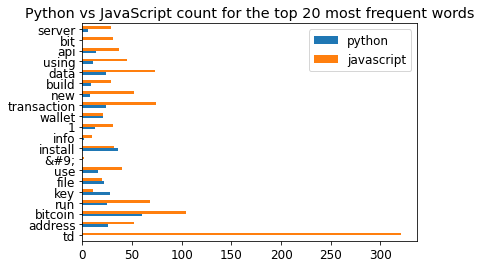

In [50]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['python', 'javascript']].plot.barh()
plt.title('Python vs JavaScript count for the top 20 most frequent words');

- C++ vs JavaScript for 20 most common words

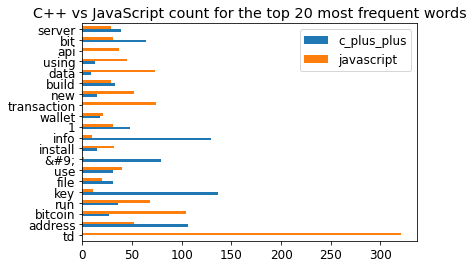

In [51]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['c_plus_plus', 'javascript']].plot.barh()
plt.title('C++ vs JavaScript count for the top 20 most frequent words');

- Java vs JavaScript for 20 most common words

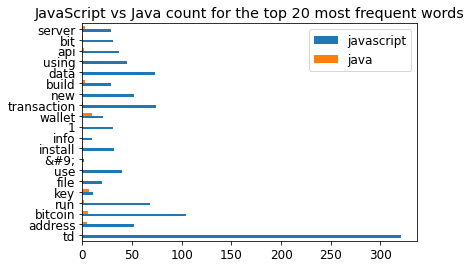

In [52]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['javascript', 'java']].plot.barh()
plt.title('JavaScript vs Java count for the top 20 most frequent words');

- JavaScript vs C for 20 most common words

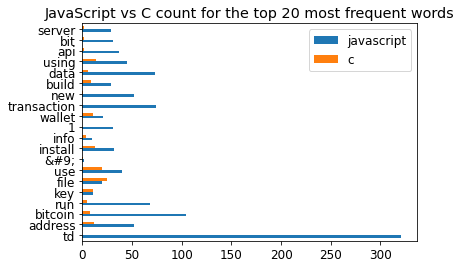

In [53]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['javascript', 'c']].plot.barh()
plt.title('JavaScript vs C count for the top 20 most frequent words');

- JavaScript vs PHP for 20 most common words

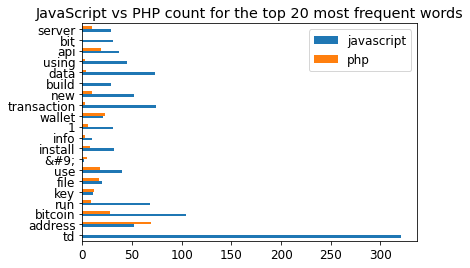

In [54]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['javascript', 'php']].plot.barh()
plt.title('JavaScript vs PHP count for the top 20 most frequent words');

- JavaScript vs other for 20 most common words

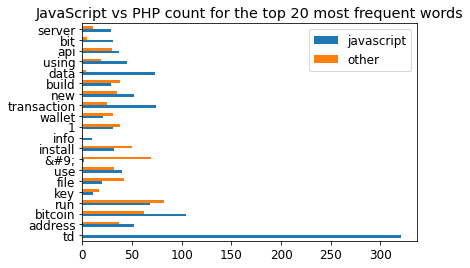

In [55]:
plt.rc('font', size=12)
word_counts.sort_values('all', ascending=False).head(20)[['javascript', 'other']].plot.barh()
plt.title('JavaScript vs PHP count for the top 20 most frequent words');

- % of JavaScript vs all for 20 most common words

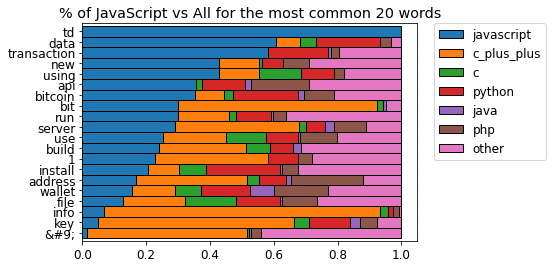

In [133]:
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of JavaScript vs All for the most common 20 words')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);

- exploring n-grams
    - what are the most common bigrams? 
    - most common bigrams by language

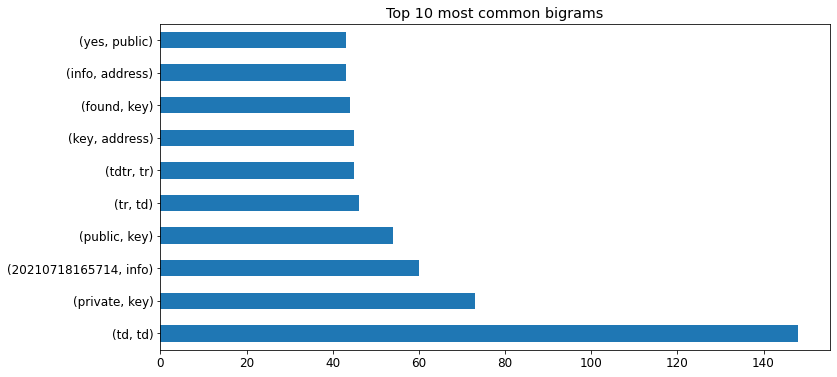

In [57]:
# most common bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common bigrams');

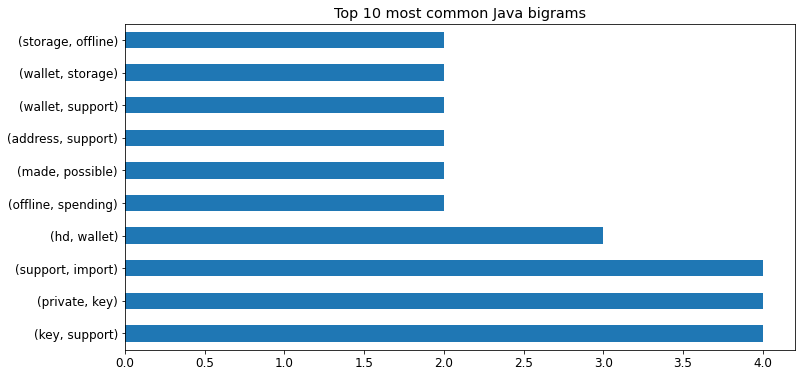

In [58]:
# most common Java bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(java_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Java bigrams');

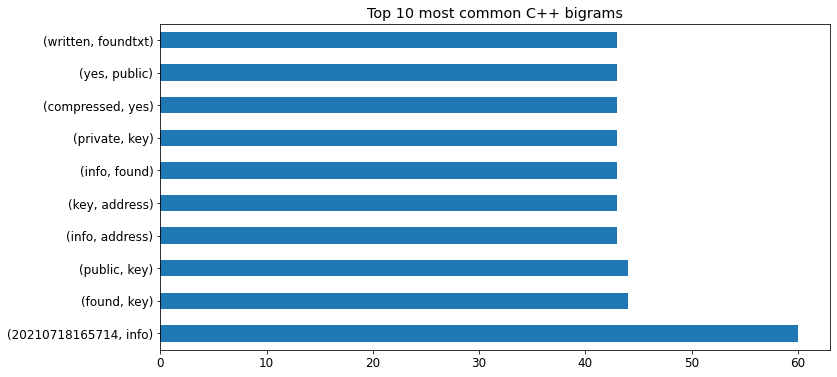

In [59]:
# most common C++ bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(c_plus_plus__words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common C++ bigrams');

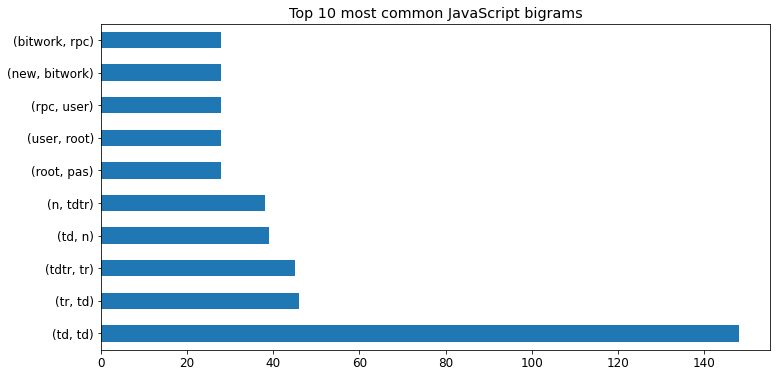

In [60]:
# most common JavaScript bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(javascript_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common JavaScript bigrams');

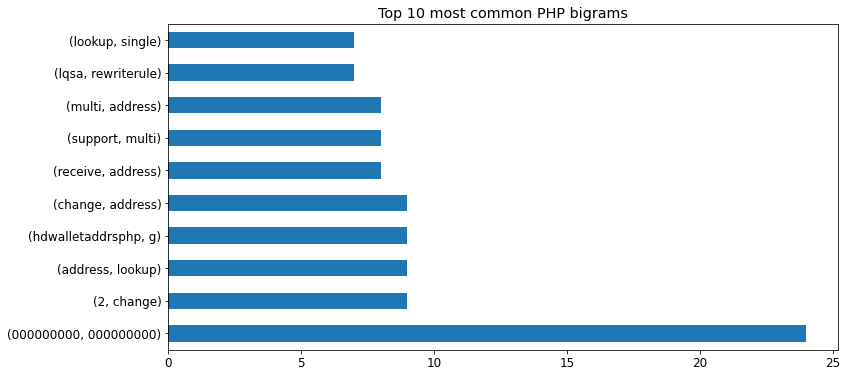

In [61]:
# most common PHP bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(php_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common PHP bigrams');

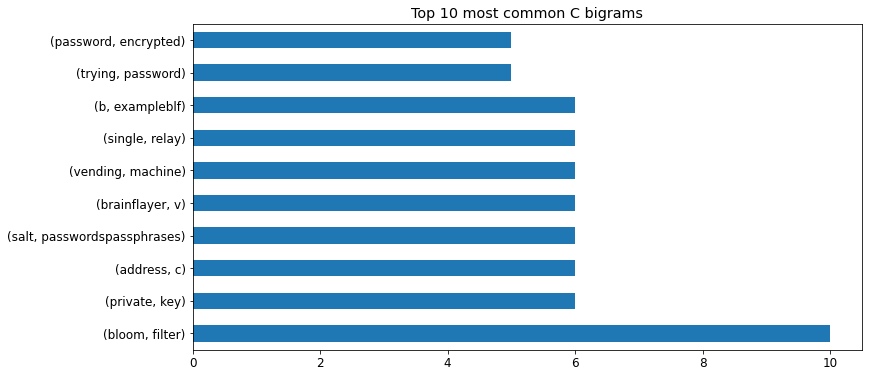

In [62]:
# most common C bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(c_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common C bigrams');

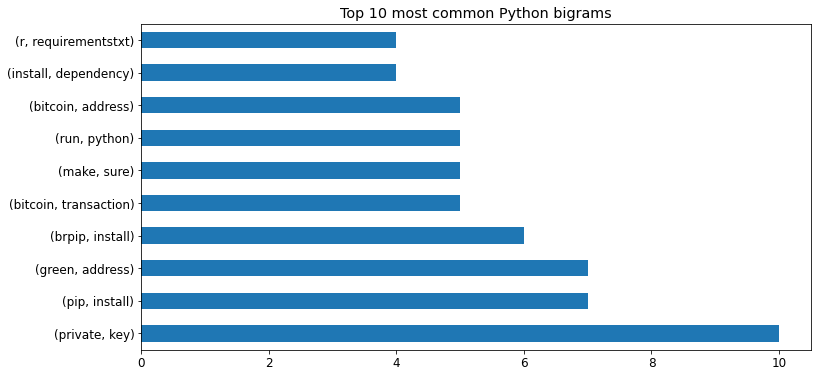

In [63]:
# most common Python bigrams

plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(python_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Python bigrams');

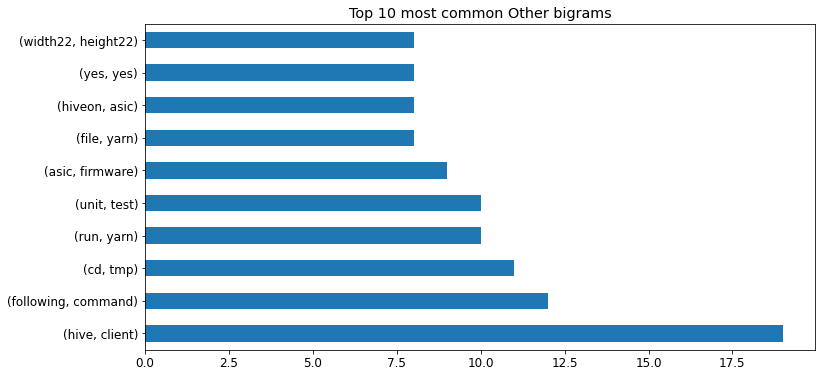

In [64]:
# most common Other bigrams
plt.figure(figsize=(12, 6))
pd.Series(nltk.bigrams(other_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common Other bigrams');

Create a word cloud of the most common words used in all

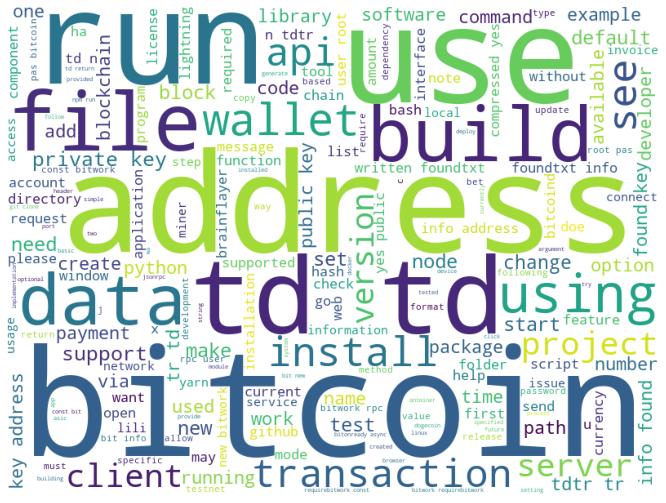

In [65]:
from wordcloud import WordCloud
plt.figure(figsize=(12, 9))
img = WordCloud(background_color='white', width=800, height=600).generate(all_words)
plt.imshow(img)
plt.axis('off');

### Modeling

### Establishing the Baseline

The last thing we have to do before fitting (training) out models is establishing a baseline.

In [66]:
train.language.value_counts(normalize=True)

Other         0.260870
JavaScript    0.250000
Python        0.206522
C++           0.097826
PHP           0.086957
C             0.065217
Java          0.032609
Name: language, dtype: float64

In [67]:
baseline = y_train.mode()

In [68]:
baseline

,language
0,Other


In [69]:
match_bsl_prediction = y_train == 'Other'

In [70]:
baseline_accuracy = match_bsl_prediction.mean()

In [71]:
# basline accuracy = 73%
baseline_accuracy

language    0.26087
dtype: float64

### X/y Split

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train = train.drop(columns=['language'])
y_train = pd.DataFrame(train.language, columns=['language'])

X_validate = validate.drop(columns=['language'])
y_validate = pd.DataFrame(validate.language, columns=['language'])

X_test = test.drop(columns=['language'])
y_test = pd.DataFrame(test.language, columns=['language'])

train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((92, 3),
 (40, 3),
 (34, 3),
 (92, 2),
 (92, 1),
 (40, 2),
 (40, 1),
 (34, 2),
 (34, 1))

### TF-IDF

In [88]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics import classification_report, accuracy_score

In [89]:
# tfidf = TfidfVectorizer()
# # X = tfidf.fit_transform(df.lemmatized)
# # y = df.language

In [90]:
# validate.shape

In [91]:
# X_train = tfidf.fit_transform(train.lemmatized)
# y_train = train.language

# X_validate = tfidf.fit_transform(validate.lemmatized)
# y_validate = validate.language

# X_test = tfidf.fit_transform(test.lemmatized)
# y_test = test.language

# train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

In [92]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [93]:
#train = pd.DataFrame(dict(actual=y_train))
#test = pd.DataFrame(dict(actual=y_test))

In [94]:
# tree1_clf = DecisionTreeClassifier(max_depth=5, random_state=123)

In [95]:
# tree1_clf = tree1_clf.fit(X_train, y_train)

In [96]:
# y_pred = tree1_clf.predict(X_train)
# y_pred[0:5]

In [97]:
# y_pred_proba = tree1_clf.predict_proba(X_train)
# y_pred_proba[0:5]

In [98]:
# # accuracy:
# print('Accuracy of Decision Tree 1 classifier on training set: {:.2f}'
#       .format(tree1_clf.score(X_train, y_train)))

In [99]:
# pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))

In [100]:
# # Test accuravy on out of sample data
# tree1_clf.score(X_validate, y_validate)

In [101]:
# # Want to find the difference to make sure there is not overfitting 
# train_accuracy = tree1_clf.score(X_train, y_train)
# validate_accuracy = tree1_clf.score(X_validate, y_validate)

In [102]:
# # Threshold is under 0.1, so we don't have to worry about overfitting
# difference = train_accuracy - validate_accuracy
# difference

In [103]:
# tree = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
# X_train['tree_predicted'] = tree.predict(X_train)
# X_test['tree_predicted'] = tree.predict(X_test)

In [104]:
# print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.tree_predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.tree_predicted, train.actual))
# print('---')
# print(classification_report(train.actual, train.tree_predicted))

### Bag of Words

In [105]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer()


In [106]:
# X_train = cv.fit_transform(train.lemmatized)
# y_train = df.language

# X_validate = cv.fit_transform(validate.lemmatized)
# y_validate = df.language

# X_test = cv.fit_transform(test.lemmatized)
# y_test = df.language

# train.shape, validate.shape, test.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

In [107]:
# X_bag_of_words.todense()

In [108]:
# cv.get_feature_names()

In [109]:
# # Shows the column location of each word
# cv.vocabulary_

In [110]:
# bow = pd.DataFrame(X_bag_of_words.todense(), columns=cv.get_feature_names())
# bow

In [111]:
# X_train, X_test, y_train, y_test = train_test_split(X_bag_of_words, y, stratify=y, test_size=.2)

# train = pd.DataFrame(dict(actual=y_train))
# test = pd.DataFrame(dict(actual=y_test))

In [112]:
# tree = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
# train['tree_predicted'] = tree.predict(X_train)
# test['tree_predicted'] = tree.predict(X_test)

In [113]:
# print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.tree_predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.tree_predicted, train.actual))
# print('---')
# print(classification_report(train.actual, train.tree_predicted))

### n-grams as a feature engineering

In [ ]:
# cv = CountVectorizer(ngram_range=(2, 2))
# bigrams = cv.fit_transform(df.lemmatized)

# pprint(df.lemmatized)
# pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())

In [ ]:
# pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())['your system']

In [ ]:
# pd.DataFrame(bigrams.todense(), columns=cv.get_feature_names())['your system'].sum()

Explore Questions: 

- What are the most frequently occuring words? 

- Are there words that uniquely identify with a certain language's repos?

In [122]:
# most frequently occuring words: sort by 'all'

word_counts.sort_values('all', ascending=False).head(20)

,javascript,c_plus_plus,c,python,java,php,other,all
td,321,0,0,0,0,0,0,321
address,52,106,12,26,5,69,37,307
bitcoin,104,27,8,60,6,28,62,295
run,68,36,5,25,2,9,82,227
key,11,136,11,28,7,12,17,222
file,20,31,25,22,1,17,42,158
use,40,31,20,16,1,18,32,158
&#9;,2,79,1,0,1,5,69,157
install,32,15,13,36,1,8,50,155
info,10,129,4,2,0,3,1,149


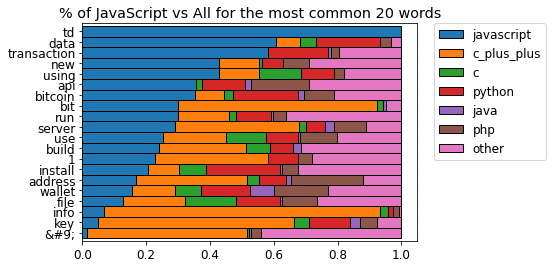

In [134]:
(word_counts.sort_values('all', ascending=False)
 .head(20)
 .apply(lambda row: row/row['all'], axis = 1)
 .drop(columns = 'all')
 .sort_values(by = 'javascript')
 .plot.barh(stacked = True, width = 1, ec = 'k')
)
plt.title('% of JavaScript vs All for the most common 20 words')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);